This code is based on: https://github.com/mdeff/cnn_graph and https://nbviewer.jupyter.org/github/mdeff/cnn_graph/blob/outputs/usage.ipynb

Reproducing license notice from https://github.com/mdeff/cnn_graph
MIT License

Copyright (c) 2016 Michaël Defferrard

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
!pip install tensorflow-gpu=="1.14"
!pip install numpy matplotlib
!pip install keras

     |████████████████████████████████| 377.0MB 46kB/s 
     |████████████████████████████████| 3.2MB 50.3MB/s 
     |████████████████████████████████| 491kB 52.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [2]:
# Download repo
!git clone https://github.com/Matimath/cnn_graph


Cloning into 'cnn_graph'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 610 (delta 15), reused 20 (delta 7), pack-reused 576
Receiving objects: 100% (610/610), 440.58 KiB | 1.42 MiB/s, done.
Resolving deltas: 100% (386/386), done.


In [3]:
# Installing tensorflow and checking version
import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'1.14.0'

In [4]:
# We need tensorflow 1.14 so we change. We also import necessary modules from the github repo we cloned
%tensorflow_version 1.14
from cnn_graph.lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
hello world


In [5]:
# Loading dataset
import keras
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


    8192/26421880 [..............................] - ETA: 0s

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# We create underlying graph as 8-NN grid of size 28x28
z = graph.grid(28)
dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

In [7]:
# We prepare coarsened versions of graphs. We also permute data so that we can use 1-D pooling as coarsening pooling as shown by defferard et. al.
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(train_images.reshape((60000, 28*28)), perm)
#X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(test_images.reshape((10000, 28*28)), perm)

Layer 0: M_0 = |V| = 912 nodes (128 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 456 nodes (48 added),|E| = 1445 edges
Layer 2: M_2 = |V| = 228 nodes (14 added),|E| = 691 edges
Layer 3: M_3 = |V| = 114 nodes (0 added),|E| = 326 edges


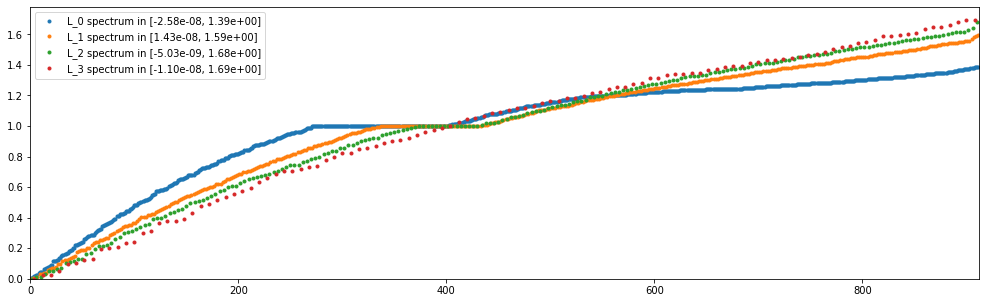

In [8]:
# Computing laplacians for initial graph and coarsened graphs
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [0]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 120
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = train_labels.max() + 1
#assert C == np.unique(y).size
n_train = 60000
# Architecture.
params['F']              = [32,32]  # Number of graph convolutional filters.
params['K']              = [3,3]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0 #5e-5
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [0]:
# Train the model
model = models.cgcnn_original(L, **params)
accuracy, loss, train_accuracy, train_loss, t_step = model.fit(X_train, train_labels, X_test, test_labels)


NN architecture
  input: M_0 = 912
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 912 * 32 / 4 = 7296
    weights: F_0 * F_1 * K_1 = 1 * 32 * 3 = 96
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 228 * 32 / 2 = 3648
    weights: F_1 * F_2 * K_2 = 32 * 32 * 3 = 3072
    biases: F_2 = 32
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3648 * 512 = 1867776
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.






step 200 / 72000 (epoch 0.33 / 120):
  learning_rate = 1.00e-03, loss_average = 1.33e+00
  validation accuracy: 54.94 (5494 / 10000), f1 (weighted): 50.84, loss: 1.31e+00
  time: 7s (wall 12s)
step 400 / 72000 (epoch 0.67 / 120):
  learning_rate = 1.00e-03, loss

In [0]:
loss

[0.6677413049340248,
 0.5592793336510659,
 0.5216266411542893,
 0.49911010086536406,
 0.46902283251285554,
 0.46231012165546415,
 0.4494735223054886,
 0.45267201513051986,
 0.43044895082712176,
 0.4466110248863697,
 0.4252961525321007,
 0.4179118874669075,
 0.42758339434862136,
 0.3926511287689209,
 0.39427189111709593,
 0.39514455050230024,
 0.3949847684800625,
 0.4081530725955963,
 0.3833735930919647,
 0.3773128740489483,
 0.38628690168261526,
 0.3719057936966419,
 0.37636962831020354,
 0.39647179931402204,
 0.36696689039468766,
 0.3915631654858589,
 0.39107815727591516,
 0.3962946064770222,
 0.3714417789876461,
 0.3992862057685852,
 0.3542359732091427,
 0.36119829714298246,
 0.3632568444311619,
 0.3562288644909859,
 0.3658541126549244,
 0.36100170373916624,
 0.3559359058737755,
 0.35173368602991106,
 0.35181689843535424,
 0.34434508755803106,
 0.3452652661502361,
 0.343814787119627,
 0.3432680568099022,
 0.3416405361890793,
 0.3511788584291935,
 0.34926760613918306,
 0.3426453566551

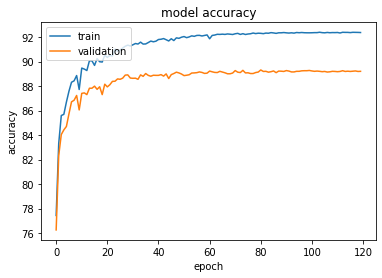

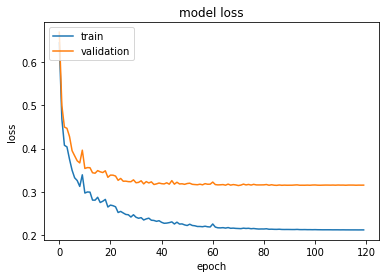

In [0]:
# Ploting code from https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy user Simone
plt.plot(train_accuracy[0::3])
plt.plot(accuracy[0::3])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_loss[0::3])
plt.plot(loss[0::3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
filename = tf.train.latest_checkpoint(model._get_path('checkpoints'))

In [0]:
filename

'/content/cnn_graph/lib/../checkpoints/demo/model-72000'

In [0]:
!ls cnn_graph/checkpoints/demo

checkpoint			 model-71600.index
model-71200.data-00000-of-00001  model-71600.meta
model-71200.index		 model-71800.data-00000-of-00001
model-71200.meta		 model-71800.index
model-71400.data-00000-of-00001  model-71800.meta
model-71400.index		 model-72000.data-00000-of-00001
model-71400.meta		 model-72000.index
model-71600.data-00000-of-00001  model-72000.meta


In [0]:
from google.colab import files
#files.download("cnn_graph/checkpoints/demo/model-72000.meta")
#files.download("cnn_graph/checkpoints/demo/model-72000.index")
files.download("cnn_graph/checkpoints/demo/model-72000.data-00000-of-00001")

MessageError: ignored

In [0]:
!cp cnn_graph/checkpoints/demo/model-72000.data-00000-of-00001 ./model-72000.data-00000-of-00001

In [0]:
#Create rotated version of datasets
rotated_test1 = np.reshape(np.rot90(test_images,1, (1,2)), (10000,28*28))
rotated_test2 = np.reshape(np.rot90(test_images,2, (1,2)), (10000,28*28))
rotated_test3 = np.reshape(np.rot90(test_images,3, (1,2)), (10000,28*28))
#graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

rotated_test1 = coarsening.perm_data(rotated_test1, perm)
rotated_test2 = coarsening.perm_data(rotated_test2, perm)
rotated_test3 = coarsening.perm_data(rotated_test3, perm)

In [0]:
# Evaluate on rotated data
res = model.evaluate(rotated_test1, test_labels)
print(res[0])
res = model.evaluate(rotated_test2, test_labels)
print(res[0])
res = model.evaluate(rotated_test3, test_labels)
print(res[0])

INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 6.33 (633 / 10000), f1 (weighted): 2.80, loss: 9.14e+00
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 21.63 (2163 / 10000), f1 (weighted): 15.34, loss: 6.66e+00
time: 1s (wall 0s)
INFO:tensorflow:Restoring parameters from /content/cnn_graph/lib/../checkpoints/demo/model-72000
accuracy: 3.83 (383 / 10000), f1 (weighted): 1.42, loss: 1.25e+01
time: 0s (wall 0s)
